In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import requests
import urllib.parse
from typing import List, Dict, Tuple
from tqdm import tqdm
import math
import warnings
from itertools import combinations
from sklearn.linear_model import LinearRegression
from geopy.distance import geodesic
import seaborn as sns
import folium
from IPython.display import IFrame
from PIL import Image


warnings.filterwarnings('ignore')
plt.style.use("ggplot")

# Analysis if travel times in europe

## Table of Contents
* [Introduction](#Introduction)
    * [Why is this topic important?](#Why-is-this-topic-important)
    * [Questions](#Questions)
* [Data gathering](#Data)
    * [Data sources](#Data-Sources)
    * [Car travel data](#Car-travel-data)
    * [Train travel data](#Train-travel-data)
        * [Duration estimation](#Train-Duration-Estimation)
    * [Air travel data](#Air-travel-data)
        * [Missing air travel data](#Missing-air-travel-data)
        * [Duration estimations](#Air-Duration-Estimation)
            * [Linear Regression](#Linear-Regression)
            * [Linear regression with basis expansion](#Linear-Regression-with-basis-expansion)  
* [Data cleaning](#Data_cleaning)
* [Exploration](#Exploration)
    * [Distributions of durations](#Distributions_of_durations)
    * [Durations based on distance](#)
    * [How much faster is it to travel by plane than train/car](#)
    * [Fastest type of transport based on countries](#section_3_2)
    * [## Which car routes have a low/high travel speed?](#sub_section_3_2_1)
## Introduction
This notebook contains the analysis of travel data inside europe between cities with or that are close to major airports. 
### Why is this topic important
Analyzing travel times in Europe holds significance in optimizing the overall travel experience, ensuring efficiency, and promoting accessibility to diverse destinations. This analysis informs strategic infrastructure development, enabling authorities to address bottlenecks and prioritize key projects for economic growth. Efficient travel times contribute to sustainability, reducing fuel consumption and emissions, while also influencing urban planning for more livable cities. By streamlining transportation, Europe can foster economic development, attract investments, and enhance the interconnectedness of its regions. In essence, the examination of travel times is pivotal for creating a well-connected, environmentally conscious, and economically vibrant European transportation landscape.

This report targets:
- Urban planers, who can use this data to help them create well connected cities which increases accessibility
- Enviromental advocates, who can use this data to promote more efficient travel options
- Travelers, who need to find the fastest way between two cities
### Questions
Based on why we think the topic is important, we have decided to answer the following questions:
- How much faster is it to travel by plane than car/train
- Are there routes on which rail leads to shorter journey times than road and air travel? 
- On which routes is the travel duration above average?
- Which is the most well-connected city in Europe in terms of minimising travel times to other cities? 

## Data
Since we were unable to find datasets which would contain all needed data, we have decided to build our own. This notebook does not contain all the code needed to gather and process data as the process takes multiple hours and also requires 2 different API keys. The code that generates the data with additional instructions is freely available on [github](https://github.com/custibor99/DOPP_GROUP25/blob/main/docs/data_docs.md). Hovwever this notebook will contain data source descriptions and simplified overview of some processing methods.
### Data Sources
The folowing data sources have been used in the project:
- [List of largest european airports](https://airmundo.com/en/blog/airport-codes-european-airports/) according to AirMundo travel agency.
- [Pythons countryinfo package](https://github.com/porimol/countryinfo) for getting neighborings of european countries.
- [Chronotrains API](https://www.chronotrains.com/en) was used for obtaining train travel times between different cities
- [Google Maps Geocode API](https://developers.google.com/maps/documentation/geocoding/overview) were used for obtaining latitude and longitude coordinates of cities
- [Google maps distance matrix api](https://developers.google.com/maps/documentation/distance-matrix/overview) used for obtaining driving distances and durations between cities.
- Airlabs [Airports](https://airlabs.co/docs/airports) and [Schedules](https://airlabs.co/docs/schedules) API used for getting airport coordinates and snapshots of flight schedules.

### Car travel data
Car travel data has been obtained using googles [Google Maps Geocode API](https://developers.google.com/maps/documentation/geocoding/overview) and [Google maps distance matrix api](https://developers.google.com/maps/documentation/distance-matrix/overview). Below is a sample code whic display how the request can be made in python.
```python
city = "LJUBLJANA"
key = "KEY"
url = f"https://maps.googleapis.com/maps/api/geocode/json?address={city}&key={key}"
url_parsed = urllib.parse.quote(url, safe="://=?&")
response = requests.get(url_parsed)
```
The response is a json object containing data about city coordinates.
### Train travel data 
The train travel data was obtained using the [Chronotrains API](https://www.chronotrains.com/en). The website uses estimations from Deutsche Bahn. There are 2 available endpoints which can be used without an API key. Their usage is shown below.


In [4]:
url = f"https://www.chronotrains.com/api/search/Ljubljana"
url_parsed = urllib.parse.quote(url, safe="://")
response = requests.get(url_parsed)
response.json()[0]

{'name': 'Ljubljana',
 'aliases': [3196359],
 'i18nNames': {'cs': 'Lublaň',
  'da': 'Ljubljana',
  'de': 'Laibach',
  'en': 'Ljubljana',
  'es': 'Liubliana',
  'fr': 'Ljubljana',
  'it': 'Lubiana',
  'nb': 'Ljubljana',
  'nl': 'Ljubljana',
  'pl': 'Lublana',
  'ro': 'Ljubljana',
  'sv': 'Ljubljana'},
 'countryCode': 'SI'}

The aliases object represents the ID of the train station that can be used to find distances between stations.

In [5]:
url = f"https://www.chronotrains.com/api/trip/3196359/724443"
url_parsed = urllib.parse.quote(url, safe="://")
response = requests.get(url_parsed)
response.json()["suggestion"]

{'originId': 3196359,
 'destinationId': 724443,
 'duration': 681,
 'changes': 2,
 'estimatedPrice': None,
 'estimatedPriceCurrency': None,
 'journey': [3196359, 7900279, 5500008, 724443],
 'geom': 'gjaxGa`pwAkPi}C~fAdwAhvJwqJoq@g}C~{@p\\dqG_wRycC_wGxeCctFg|@syVpb@oyHtjE}lEzKe`Fw~Hg`J{{AadYguAyAkmD{|Nit@fwCsqClO{h@tdKebE`wDwrCskGipDboCor@crFgcJ_DejEghFvyBop_@{fHrXwM{yGobD}zCmdBgrK}sIkVs~FyjSrCyi_@ynD_|HnwD_zt@mvCm}@g_MjwDw}A}kIq|Ef~EihO}cGogChsF{tIjxBc}OwxAaqAscB{{Aet[??e`Dsts@}{DoxV||DcpYctFgkFwWccFqeG__IchHetEcv@qlLusG}qTgyF}Cs`Hr|Cq_I{uBleEyqN|tB{c[bfF}~Mn@ciEmgN_r[rbCol@oe@gfJp|BgqKawAgsNrgC_`Csq@upL{{GinWlU_fEw`EupEprCydJsYsiaAgqJ_{WkhPa|SgvHqkTodFyzY_`IdkB??s_Dkb[oaBnp@{nAcmJajFqtJm`GxPlTuwVo`EkeCitCokKtsCgkXa`EeeKa|B}x@x_AsoImlC}yh@}vE}mUquFapnAg_\\{f`Ae_DamCydKszAw{Qp{FdjAecOw|T{aIq~Xyzb@qz_@}uRokQcnPi~V~bI'}

#### Train Duration Estimation 
The provided estimations were mostly reasonable when you were traveling inside a country and between neighboring countries, but if we wanted to receive an estimate for a long route that would travel between multiple countries the API did not produce any results. This is why we have decided to estimate the train travel durations. The idea of the algorithms is that we get the travel times between cities in the same country and neighboring countries and connect them in a graph. Afterwards we can use a shortest path algorithm to estimate the duration of any path as long as their exist a connection in the graph. The graph creation pseudo code is provided below
```
Create an empty graph G
Add all cities to G as nodes
For each city in a country:
		get the travel duration to all other cities in the country
        add the travel durations to the graph

		get the travel durations to all cities from neighboring countries
		add the travel durations to the graph
```

### Air travel data
Our network of airports was built from the [list of largest european airports](https://airmundo.com/en/blog/airport-codes-european-airports/) according to AirMundo travel agency. Just like the above graph for train stations, they represent nodes connected by edges containing the distance between them.

```
Create an empty graph G
Add all airports to G as nodes
For each airport pair a,b:
		Calculate distance from a to b
        Add an edge (a,b) with the distance as attribute
```

Airport coordinates were taken from the [Airlabs Airports API](https://airlabs.co/docs/airports) by querying the iata-codes from the above mentioned list of airports.

```
Airlabs Airports API call: https://airlabs.co/api/v9/airports?iata_code={iata_code}&api_key={KEY}
```

#### Missing air travel data
Only [one source (OpenFlights)](https://github.com/jpatokal/openflights/tree/master/data) provided free records of flight data, but it was outdated by about 8 years and was missing many of today's flight routes. Our air travel is therefore a hypothetical network where all airports are connected, regardless of them having any real world routes between them.

Other than car and train data, there was no dataset or API that would give us the duration of flights. We tried web scraping data from sites like [FlightAware](https://de.flightaware.com) or [Flightradar24](https://www.flightradar24.com). FlightAware would have provided flight codes by searching through all pairs of iata codes. Flightradar24 would provide flight history, as well as average durations for each flight code. However, this would have taken too many processing hours for our task (up to several days).

#### Air Duration Estimation
Our first approach was calculating the duration using distance and average flight speed. Short comparisons with real world data showed that we could not get accurate enough results with this approach.

We finally opted for creating a regression model to estimate flight duration based on travel distance. The [Airlabs Schedules API](https://airlabs.co/docs/schedules) provides live schedule data, which contains estimated flight durations, as well as real flight durations for flights that have already concluded.

```
Airlabs Schedules API call: https://airlabs.co/api/v9/schedules?dep_iata={airport_iata}&api_key={API_KEY}
```

In [6]:
airport_data = pd.read_csv("../data/clean/airport_data.csv")
airport_network = nx.read_gml("../data/airport_network.gml")
schedules = pd.read_csv("../data/airport_schedules.csv")

# Only consider schedules that are within our european airport network
schedules = schedules[schedules["arr_iata"].isin(airport_data["iata_code"])]
display(schedules)

,airline_iata,airline_icao,flight_iata,flight_icao,flight_number,dep_iata,dep_icao,dep_terminal,dep_gate,dep_time,...,arr_delayed,aircraft_icao,arr_time_ts,dep_time_ts,arr_estimated_ts,dep_estimated_ts,dep_actual_ts,arr_actual,arr_actual_utc,arr_actual_ts
0,W9,WUK,W94466,WUK4466,4466,TIA,LATI,NaN,NaN,2024-01-04 12:25,...,NaN,NaN,1704380100,1704367500,1.704379e+09,1.704367e+09,1.704367e+09,NaN,NaN,NaN
1,W4,WMT,W46633,WMT6633,6633,TIA,LATI,NaN,NaN,2024-01-04 12:30,...,9.0,NaN,1704378600,1704367800,1.704379e+09,1.704367e+09,1.704367e+09,NaN,NaN,NaN
2,ZB,ABN,ZB2011,ABN2011,2011,TIA,LATI,NaN,NaN,2024-01-04 12:40,...,NaN,A319,1704375600,1704368400,NaN,NaN,NaN,NaN,NaN,NaN
3,2B,AWT,2B233,AWT233,233,TIA,LATI,NaN,NaN,2024-01-04 12:00,...,NaN,B734,1704372600,1704366000,NaN,1.704369e+09,1.704369e+09,NaN,NaN,NaN
4,W4,WMT,W46673,WMT6673,6673,TIA,LATI,NaN,NaN,2024-01-04 12:55,...,NaN,NaN,1704375000,1704369300,NaN,1.704369e+09,1.704369e+09,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22960,BA,BAW,BA4064,BAW4064,4064,SOU,EGHI,NaN,NaN,2024-01-08 19:55,...,NaN,NaN,1704748800,1704743700,NaN,NaN,NaN,NaN,NaN,NaN
22962,LM,LOG,LM490,LOG490,490,SOU,EGHI,NaN,NaN,2024-01-08 19:55,...,NaN,E145,1704748800,1704743700,NaN,NaN,NaN,NaN,NaN,NaN
22963,EI,EIN,EI3309,EIN3309,3309,SOU,EGHI,NaN,NaN,2024-01-08 20:10,...,NaN,NaN,1704750300,1704744600,NaN,NaN,NaN,NaN,NaN,NaN
22964,EA,EAI,EA3309,EAI3309,3309,SOU,EGHI,NaN,NaN,2024-01-08 20:10,...,NaN,NaN,1704750300,1704744600,NaN,NaN,NaN,NaN,NaN,NaN


Removing all flights that haven't landed yet (arr_actual being NaN) left us with only 344 entries. We therefore chose to use the estimated time from the "duration" column to be able to use all ~5500 data points. We also remove alot of duplicate entries, as well as obvious outliers (over 16 hours travel time for distances under 100km).


In [7]:
schedules = schedules[["dep_iata", "arr_iata", "duration"]]
schedules.dropna(inplace=True)
schedules.drop_duplicates(inplace=True)
schedules.reset_index(drop=True, inplace=True)

# Remove outliers
schedules = schedules[~(schedules["duration"] > 1000)]

# Get distances from airport network 
for i, (dep, arr) in schedules[["dep_iata", "arr_iata"]].iterrows():
    if airport_network.has_edge(dep, arr):
        schedules.at[i, "distance"] = airport_network.edges[dep, arr]["distance"]

display(schedules.head())

,dep_iata,arr_iata,duration,distance
0,TIA,LTN,210,1912943.0
1,TIA,BVA,180,1631963.0
2,TIA,VRN,120,837947.0
3,TIA,BGY,110,933984.0
4,TIA,CIY,95,659725.0


#### Linear Regression
Experimentation with a naive linear model shows a slight curve in the relationship between distance and duration .

In [8]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
X = schedules["distance"].values.reshape(-1, 1)
y = schedules["duration"].values.reshape(-1, 1)
model.fit(X, y)

LinearRegression()

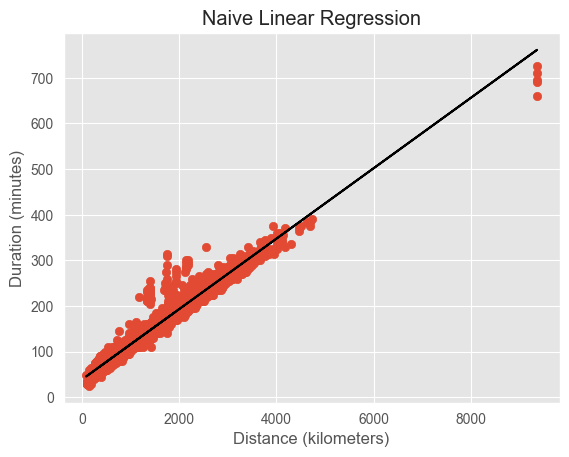

In [9]:
# plotting the model
fig = plt.figure()
ax = fig.add_subplot()

m2km = lambda x, _: f'{x/1000:g}'
ax.xaxis.set_major_formatter(m2km)

ax.scatter(schedules["distance"], schedules["duration"])
ax.plot(X, model.predict(X), color="black")
plt.title("Naive Linear Regression")
plt.xlabel("Distance (kilometers)")
plt.ylabel("Duration (minutes)")
plt.show()

#### Linear Regression with basis expansion
We chose Linear Regression with basis expansion, to fit this curve.

In [10]:
from sklearn.preprocessing import PolynomialFeatures

X = schedules["distance"].values.reshape(-1, 1)
y = schedules["duration"].values.reshape(-1, 1)

degree = 3
poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(X)

model_be = LinearRegression()
model_be.fit(X_poly, y)

LinearRegression()

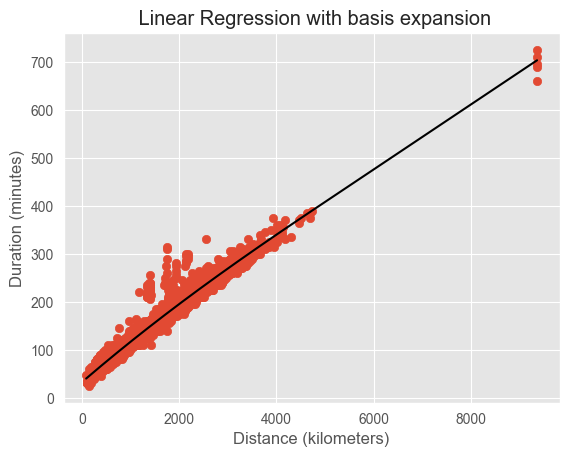

In [11]:
fig = plt.figure()
ax = fig.add_subplot()

m2km = lambda x, _: f'{x/1000:g}'
ax.xaxis.set_major_formatter(m2km)

X_sorted = np.sort(X, axis=0)
X_sorted_poly = poly_features.transform(X_sorted)

ax.scatter(schedules["distance"], schedules["duration"])
ax.plot(X_sorted, model_be.predict(X_sorted_poly), color='black')
plt.title(" Linear Regression with basis expansion")
plt.xlabel("Distance (kilometers)")
plt.ylabel("Duration (minutes)")
plt.show()

### Calculating the Root-mean-square deviation
Comparing both models we can see that the second approach is better suited for the data.

In [13]:
def calculate_rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_pred - y_true) ** 2))

print("RMSE:")
print("Naive: ", calculate_rmse(y, model.predict(X)))
print("Basis expansion: ", calculate_rmse(y, model_be.predict(X_poly)))

RMSE:
Naive:  12.285316032004857
Basis expansion:  11.93301388607644


# Exploration

In [11]:
def get_nodes_by_type(g: nx.Graph, type:str) -> List[str]:
    return [city for city, typ in nx.get_node_attributes(g, "type").items() if typ == type]

def get_edges_by_type(g:nx.Graph, edge_type:str) -> List[Tuple[str, str]]:
    return [edge for edge, type in nx.get_edge_attributes(g, "type").items() if type == edge_type]

def get_neighbors_by_type(g:nx.Graph, location:str, type:str) -> List[str]:
    neighbors = []
    if type != "City" and type != "Airport" and type != "Station":
        raise ValueError(f"Unvalid type '{type}'")
    for node in g.adj[location]:
        if g.nodes[node]["type"] == type:
             neighbors.append(node) 
    return neighbors

def get_airplane_duration(g: nx.Graph, source_city:str, destination_city:str, airport_wait_minutes = 75) -> List[Dict[List[str], int]]:
    if source_city == destination_city:
        source_city.capitalize()
        destination_city.capitalize()
        warnings.warn("Source and destination city are the same")
        return 0
    assert g.has_node(source_city), f"{source_city} is not in network"
    assert g.has_node(destination_city), f"{destination_city} is not in network"

    source_airports = get_neighbors_by_type(g, source_city, type="Airport")
    destination_airports = get_neighbors_by_type(g, destination_city, type="Airport")
    possible_coombinations = [(source, destination)for source in source_airports for destination in destination_airports]

    durations = []
    for source_airport, destination_airport in possible_coombinations:
        route = {
            "nodes": [source_city, source_airport, destination_airport, destination_city],
            "duration": 0
        }
        route["duration"] += g[source_city][source_airport]["duration"]
        route["duration"] += g[source_airport][destination_airport]["duration"]
        route["duration"] += g[destination_airport][destination_city]["duration"]
        route["duration"] += airport_wait_minutes
        durations.append(route)
    return durations


def get_car_duration(g: nx.Graph, source_city:str, destination_city:str) -> List[Dict[List[str], int]]:
    if source_city == destination_city:
        source_city.capitalize()
        destination_city.capitalize()
        warnings.warn("Source and destination city are the same")
        return 0
    assert g.has_node(source_city), f"{source_city} is not in network"
    assert g.has_node(destination_city), f"{destination_city} is not in network"

    route = {
        "nodes": [source_city, destination_city],
        "duration": g[source_city][destination_city]["duration"]
    }
    
    return [route]

def get_train_duration(g: nx.Graph, source_city:str, destination_city:str, train_wait_minutes = 10) -> List[Dict[List[str], int]]:
    def filter_train_edges(n1, n2):
        type =  g[n1][n2].get("type", "none")
        return type == "train"
    
    if source_city == destination_city:
        source_city.capitalize()
        destination_city.capitalize()
        warnings.warn("Source and destination city are the same")
        return 0
        
    assert g.has_node(source_city), f"{source_city} is not in network"
    assert g.has_node(destination_city), f"{destination_city} is not in network"

    source_airports = get_neighbors_by_type(g, source_city, type="Station")
    destination_airports = get_neighbors_by_type(g, destination_city, type="Station")
    possible_coombinations = [(source, destination)for source in source_airports for destination in destination_airports]

    durations = []
    for source_station, destination_station in possible_coombinations:
        route = {
            "nodes": [source_city],
            "duration": 0
        }
        subgraph = nx.subgraph_view(g, filter_edge=filter_train_edges)
        shortest_path = nx.shortest_path(subgraph, source=source_station, target=destination_station, weight="duration")
        route["nodes"] += shortest_path + [destination_city]
        route["duration"] = nx.path_weight(g, shortest_path, "duration")
        route["duration"] += g[source_city][source_station]["duration"]
        route["duration"] += g[destination_city][destination_station]["duration"]
        durations.append(route)  
    return durations

def calculate_distance(lat1, lon1, lat2, lon2) -> int:
    earth_radius = 6371e3
    delta_lat = math.radians(lat2 - lat1)
    delta_lon = math.radians(lon2 - lon1)

    a = (math.sin(delta_lat / 2) ** 2 +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(delta_lon / 2) ** 2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    return round(earth_radius * c)

def build_coombinations(l: List[str]):
    for i, node1 in enumerate(l):
        for j in range(i+1,len(l)):
                yield (l[i], l[j])


def get_durations_by_transport_type(g:nx.Graph, type:str, weight="duration")-> List[int]:
    # Get all car durations
    nodes = get_nodes_by_type(g, type)
    durations = []
    coombinations = build_coombinations(nodes)
    if type == "City" or "Airport":
        for source, dest in tqdm.tqdm(coombinations):
            durations.append(g[source][dest].get(weight, None))
    else:
        for source, dest in tqdm.tqdm(coombinations):
            try:
                durations.append(nx.shortest_path_length(g, source, dest, "duration"))
            except:
                pass
    return durations

def calculate_distance(city1, city2):
    pos1 = g.nodes[city1]["pos"]
    pos2 = g.nodes[city2]["pos"]
    return geodesic(pos1, pos2).kilometers

g = nx.read_gml("../data/clean/all_routes.gml")
all_data = pd.read_csv("../data/clean/all_data.csv")

### Create a dataframe
To be able to analyse the data we need it in a fitting format.
Lets create a dataframe where every line is a connection between two cities. We want to include the distance and the traveltimes with car, train and plane.

We have 150 cities which means we get around 150^2/2=29929/2 < 15000 which should be no problem to process.

In [12]:
# Built a dataframe
data = []

# get all citynodes
city_nodes = [node for node in g.nodes if g.nodes[node]["type"] == "City"]

# iterate through city nodes
for city1, city2 in combinations(city_nodes, 2):

    distance = calculate_distance(city1, city2)
    
    # get car_duration
    car_durations = get_car_duration(g, city1, city2)
    car_duration = car_durations[0]["duration"] if car_durations else None
    
    # get train_duration
    try:
        train_durations = get_train_duration(g, city1, city2)
        train_duration = train_durations[0]["duration"] if train_durations else None
    except nx.NetworkXNoPath:
        train_duration = None
    
    # get plane_duration
    plane_durations = get_airplane_duration(g, city1, city2, airport_wait_minutes=75)
    plane_duration = min(route["duration"] for route in plane_durations) if plane_durations else None

    data.append([city1, city2, distance, car_duration, train_duration, plane_duration])

result_df = pd.DataFrame(data, columns=["city1", "city2", "distance", "car_duration", "train_duration", "plane_duration"])


# Include Countries of city1 and city2:

country_information = all_data[["city", "Country"]]
# some cities appear more than once(because they have multiple airports)
country_information = country_information.drop_duplicates(subset='city')

result_df = result_df.merge(country_information, left_on='city1', right_on='city', how='left')
result_df = result_df.rename(columns={'Country': 'country1'})
result_df = result_df.drop('city', axis=1)

result_df = result_df.merge(country_information, left_on='city2', right_on='city', how='left')
result_df = result_df.rename(columns={'Country': 'country2'})
result_df = result_df.drop('city', axis=1)


# Add Column fastest_transportation

result_df['fastest_transportation'] = result_df[['car_duration', 'train_duration', 'plane_duration']].idxmin(axis=1)

# Map the column names to transportation modes (train, car, plane)
transportation_mapping = {'car_duration': 'car', 'train_duration': 'train', 'plane_duration': 'plane'}
result_df['fastest_transportation'] = result_df['fastest_transportation'].map(transportation_mapping)


result_df.head()

,city1,city2,distance,car_duration,train_duration,plane_duration,country1,country2,fastest_transportation
0,Graz,Innsbruck,306.702101,298,370.800000,216.000000,Austria,Austria,plane
1,Graz,Klagenfurt,98.595632,96,189.383333,192.216667,Austria,Austria,car
2,Graz,Linz,162.456030,150,197.900000,216.216667,Austria,Austria,car
3,Graz,Salzburg,197.716117,182,257.016667,211.716667,Austria,Austria,car
4,Graz,Vienna,144.572948,133,166.583333,214.833333,Austria,Austria,car


### Distributions of durations

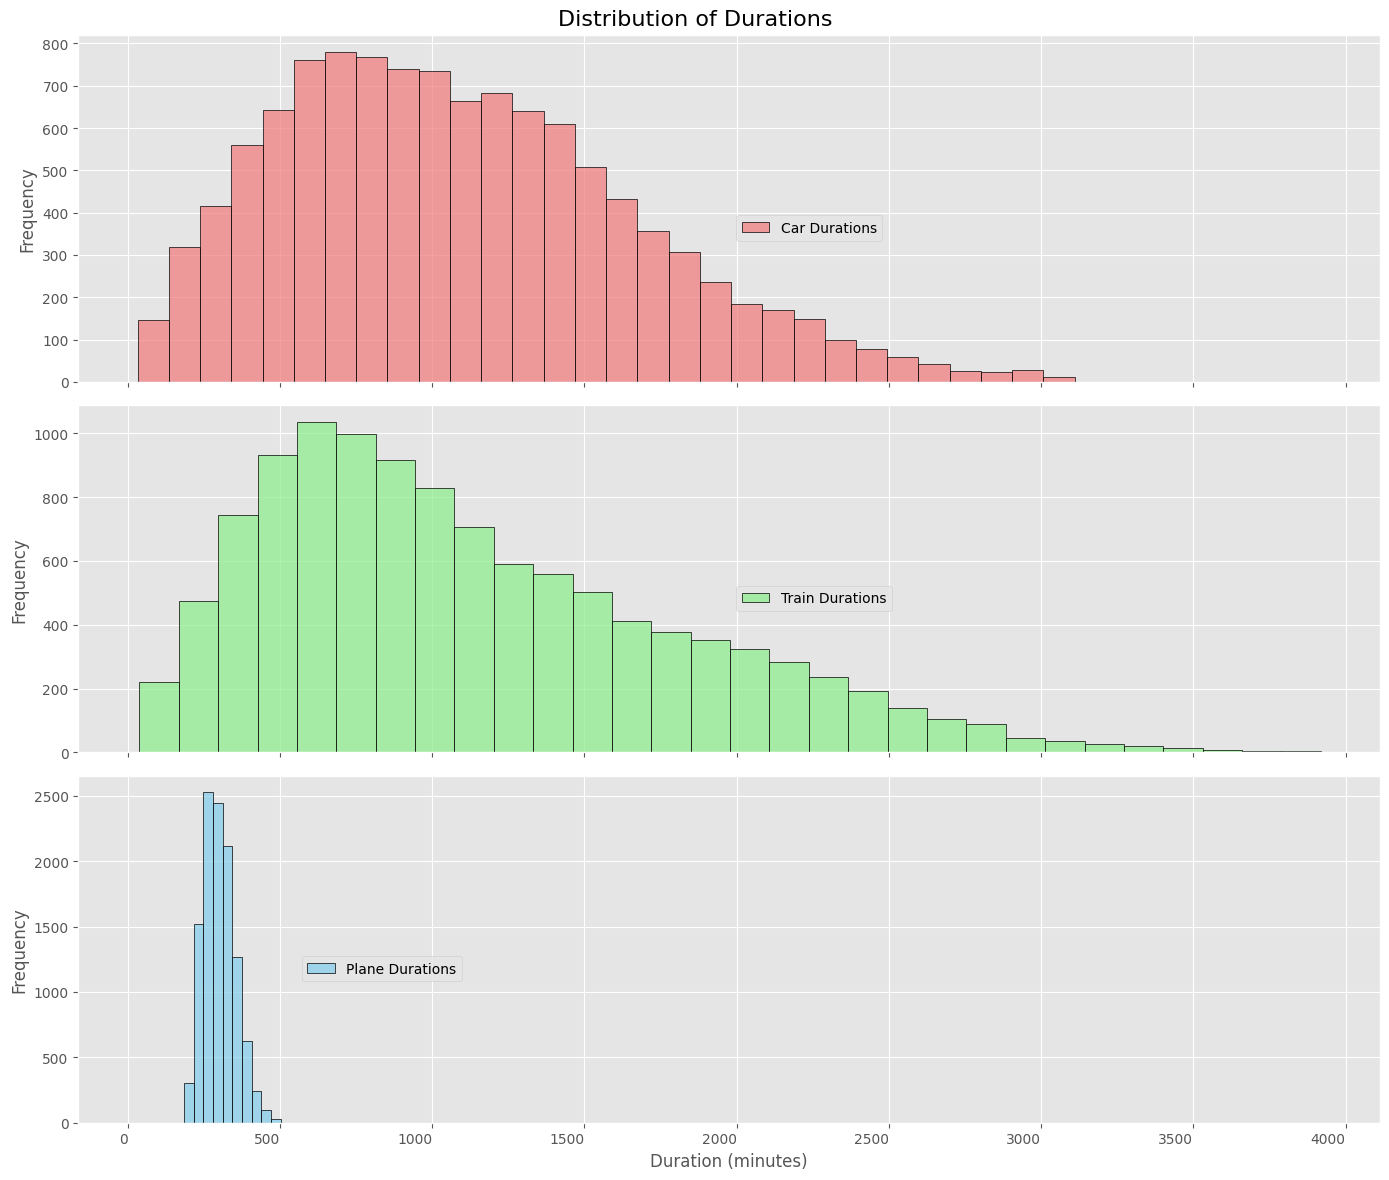

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(14, 12), sharex=True)

plt.suptitle('Distribution of Durations', fontsize=16)

# Plot histogram for car durations
sns.histplot(result_df['car_duration'].dropna(), bins=30, color='lightcoral', edgecolor='black', ax=ax1)
ax1.set_xlabel('Duration (minutes)')
ax1.set_ylabel('Frequency')
ax1.legend(['Car Durations'], bbox_to_anchor=(0.5, 0.5), fancybox=True, fontsize='medium')

# Plot histogram for train durations
sns.histplot(result_df['train_duration'].dropna(), bins=30, color='lightgreen', edgecolor='black', ax=ax2)
ax2.set_xlabel('Duration (minutes)')
ax2.set_ylabel('Frequency')
ax2.legend(['Train Durations'], bbox_to_anchor=(0.5, 0.5), fancybox=True, fontsize='medium')

# Plot histogram for plane durations
sns.histplot(result_df['plane_duration'].dropna(), bins=10, color='skyblue', edgecolor='black', ax=ax3)
ax3.set_xlabel('Duration (minutes)')
ax3.set_ylabel('Frequency')
ax3.legend(['Plane Durations'], bbox_to_anchor=(0.3, 0.5), fancybox=True, fontsize='medium')

plt.tight_layout()
plt.xticks(ha='right')
plt.show()

Above we can see that car and train travel times have a very similar distribution, wich could suggest that the travel times between cities are most of the time also very similar. We can also see that the plane durations have a much smaller mean (should be faster in most cases).

### Durations based on distance

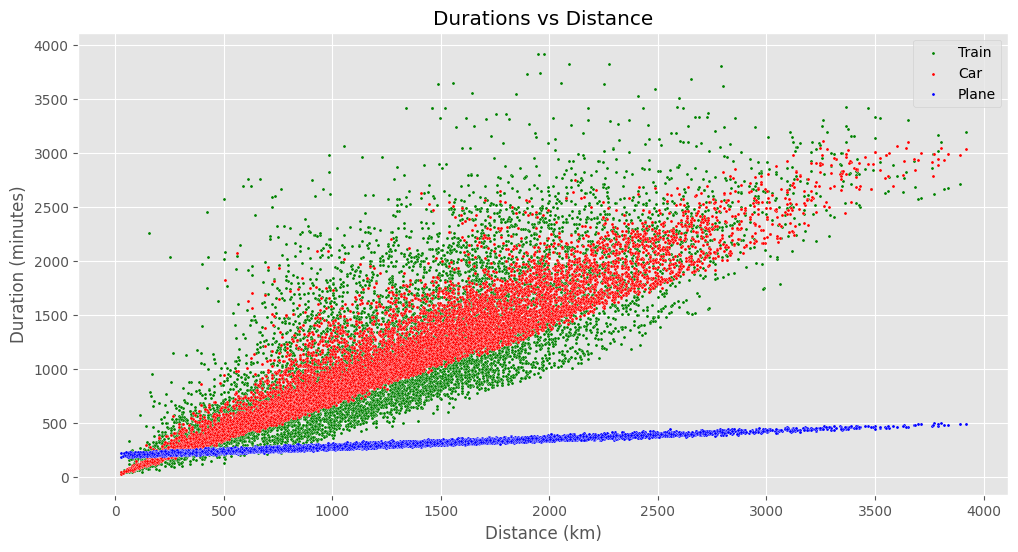

In [14]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=result_df, x='distance', y='train_duration', label='Train', color='green', s=5)
sns.scatterplot(data=result_df, x='distance', y='car_duration', label='Car', color='red', s=5)
sns.scatterplot(data=result_df, x='distance', y='plane_duration', label='Plane', color='blue', s=5)

plt.title('Durations vs Distance')
plt.xlabel('Distance (km)')
plt.ylabel('Duration (minutes)')
plt.legend()
plt.show()

For all 3 modes of transportations we can see that the travel duration increases almost linearly based on the geospatial distance. For plane travel this was expected as we estimated the durations with a linear model. We can also notice that the variance of durations for trains and cars increases as the geospatial distance increases, this is probably because the actuall distance matches the geospatial distance when the distance is short and the difference between the actuall distance and geospatial distance increases as the geospatial distance increases.

# How much faster is it to travel by plane than train/car

In [15]:
def calculate_distance(lat1, lon1, lat2, lon2) -> int:
    earth_radius = 6371e3
    delta_lat = math.radians(lat2 - lat1)
    delta_lon = math.radians(lon2 - lon1)

    a = (math.sin(delta_lat / 2) ** 2 +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(delta_lon / 2) ** 2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    return round(earth_radius * c)
    
    
cities = get_nodes_by_type(g, "City")
possible_routes = build_coombinations(cities)
car_duration = []
plane_duration = []
train_duration = []
air_distances = []
sources = []
destinations = []

for source, dest in tqdm(possible_routes):
    
    car_duration.append(get_car_duration(g, source, dest)[0]["duration"])
    plane_duration.append(get_airplane_duration(g, source, dest)[0]["duration"])
    train_duration.append(get_train_duration(g, source, dest)[0]["duration"])
    
    lat1, lng1 = g.nodes[source]["pos"]
    lat2, lng2 = g.nodes[dest]["pos"]
    air_distances.append(calculate_distance(lat1, lng1, lat2, lng2))
    sources.append(source)
    destinations.append(dest)

car_duration = np.array(car_duration)
plane_duration = np.array(plane_duration)
train_duration = np.array(train_duration)

train_plain_ratio = np.array(train_duration) / np.array(plane_duration)
car_plane_ratio = np.array(car_duration) / np.array(plane_duration) 
train_car_ratio = np.array(train_duration) / np.array(car_duration) 
air_distances = np.array(air_distances)

11175it [00:27, 402.65it/s]


Trains are faster than planes 3.94 % of the time
Cars are faster than planes 3.86 % of the time
Trains are faster than cars 48.43 % of the time


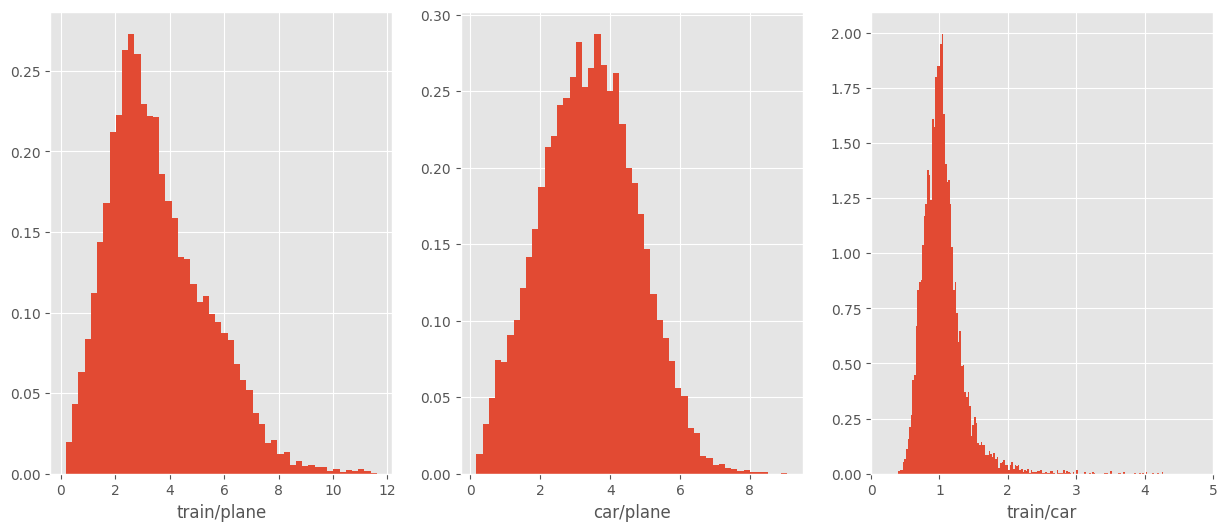

In [16]:
fig, ax = plt.subplots(1,3, figsize=(15,6))
ax[0].hist(train_plain_ratio, bins=50, density=True)
print("Trains are faster than planes",round(sum(train_plain_ratio < 1) / len(train_plain_ratio) * 100, 2), "% of the time")
ax[1].hist(car_plane_ratio, bins=50, density=True)
print("Cars are faster than planes", round(sum(car_plane_ratio < 1) / len(train_plain_ratio) * 100, 2), "% of the time")
ax[2].hist(train_car_ratio, bins=500, density=True)
print("Trains are faster than cars", round(sum(train_car_ratio < 1) / len(train_plain_ratio) * 100, 2), "% of the time")
ax[0].set_xlabel("train/plane")
ax[2].set_xlim(0,5)
ax[1].set_xlabel("car/plane")
ax[2].set_xlabel("train/car")
plt.show()

From the distributions above we can see that the train/plane and car/plane distributions are very similar which again confirms our hypothesis that the "performance" of cars and train is similar. This information can be used for enviromentalist who want to dispay the efficience of trains.

### Change of ratios based on distances

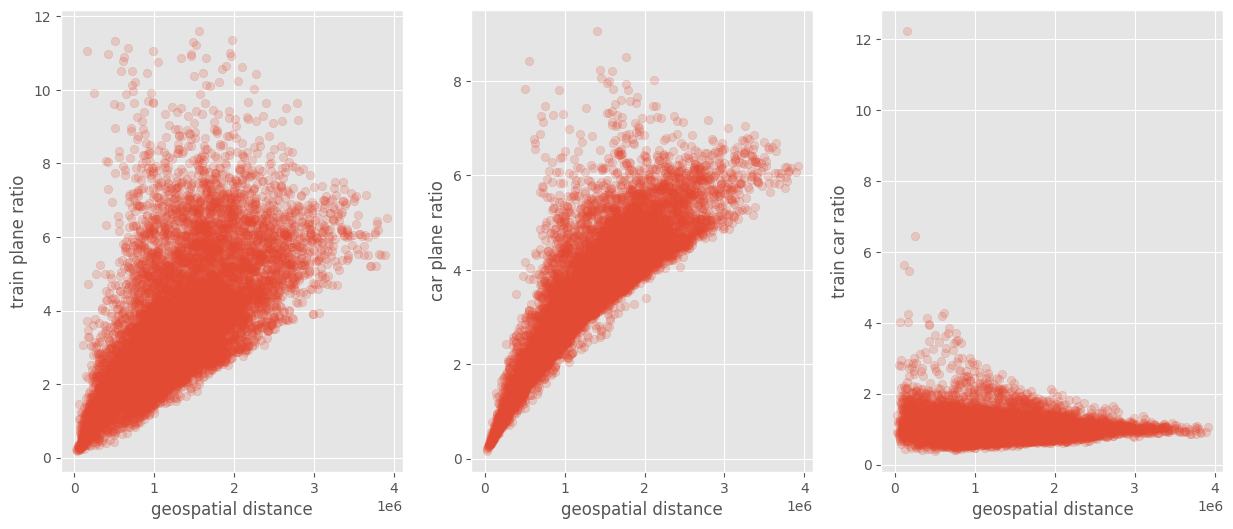

In [17]:
fig, ax = plt.subplots(1,3, figsize=(15,6))
ax[0].scatter(air_distances, train_plain_ratio, alpha=0.2)
ax[1].scatter(air_distances, car_plane_ratio, alpha=0.2)
ax[2].scatter(air_distances, train_car_ratio, alpha=0.2)

ax[0].set_xlabel("geospatial distance")
ax[1].set_xlabel("geospatial distance")
ax[2].set_xlabel("geospatial distance")

ax[0].set_ylabel("train plane ratio")
ax[1].set_ylabel("car plane ratio")
ax[2].set_ylabel("train car ratio")
plt.show()

Above we can see what we can see that planes become much more efficient than train and cars on longer distances. But we cannot see such a trend in the train and car ratio that we calculated which could suggest, that the effectivnes of cars compared of trains does not change based on the traveled distance.

### Fastest type of transport based on countries:

In [18]:
country_df = all_data["Country"]
country_df = pd.DataFrame(country_df.drop_duplicates())


def get_fastest_transportation_distribution(row):
    country_input = row['Country']
    
    country_data = result_df[(result_df['country1'] == country_input) & (result_df['country2'] == country_input)]

    class_counts = country_data['fastest_transportation'].value_counts()
    class_fractions = class_counts / len(country_data)

    row['plane'] =  class_fractions.get("plane", None)
    row['train'] = class_fractions.get("train", None)
    row['car'] = class_fractions.get("car", None)
    row["total_routes"] = len(country_data)
    return row

country_df = country_df.apply(get_fastest_transportation_distribution, axis = 1).dropna()

country_df = pd.DataFrame(country_df[country_df["total_routes"] >= 10])

print(country_df)

            Country     plane     train       car  total_routes
0           Austria  0.200000  0.266667  0.533333            15
20          Finland  0.533333  0.400000  0.066667            15
26           France  0.606061  0.287879  0.106061            66
41          Germany  0.522876  0.333333  0.143791           153
65            Italy  0.628571  0.247619  0.123810           210
93      Netherlands  0.100000  0.300000  0.600000            10
99           Norway  0.809524  0.047619  0.142857            21
106          Poland  0.428571  0.285714  0.285714            21
126           Spain  0.666667  0.217949  0.115385            78
154  United Kingdom  0.461538  0.397436  0.141026            78


In [19]:
result_df["duration_plane_minus_car"] = result_df["plane_duration"] - result_df["car_duration"]
result_df["duration_plane_minus_train"] = result_df["plane_duration"] - result_df["train_duration"]
filtered_df200 = result_df[result_df['distance']< 200]
filtered_df200_500 = result_df[(result_df['distance']>= 200) & (result_df['distance']<500)]
filtered_df500_1000 = result_df[(result_df['distance']>= 500) & (result_df['distance']<1000)]
filtered_df1000 = result_df[result_df['distance']>= 1000]

filtered_dfs = [result_df, filtered_df200, filtered_df200_500, filtered_df500_1000, filtered_df1000]
filtered_df_names = ['result_df', 'filtered_df200', 'filtered_df200_500', 'filtered_df500_1000', 'filtered_df1000']

mean_results_df = pd.DataFrame(columns=['duration_plane_minus_car', 'duration_plane_minus_train'])

for df, df_name in zip(filtered_dfs, filtered_df_names):
    mean_results_df.loc[df_name] = df[['duration_plane_minus_car', 'duration_plane_minus_train']].mean()
mean_results_df.index = ["all routes", "routes < 200km", "200km <= routes < 500km", "500km <= routes < 1000kkm", "routes >= 1000km" ]
mean_results_df

,duration_plane_minus_car,duration_plane_minus_train
all routes,-785.572453,-834.270911
routes < 200km,81.196981,34.286836
200km <= routes < 500km,-99.116621,-151.949651
500km <= routes < 1000kkm,-422.127201,-476.208732
routes >= 1000km,-1096.906575,-1142.572264


We can see that the effectivnes of air travel increases by distance.

## Which car routes have a low/high travel speed?


In [20]:
possible_routes = build_coombinations(cities)

ratios = []

for source, dest in possible_routes:
    duration = get_car_duration(g, source, dest)[0]["duration"]
    distance = g[source][dest]["distance"]
    ratio = distance / duration * 60 
    ratios.append((ratio, (source, dest)))
sorted_paths = sorted(ratios, key= lambda x: x[0])
slowest_paths = sorted_paths[0:10]
fastest_paths = sorted_paths[-10:]

print("Slow routes")
for speed, route in slowest_paths:
    source, dest = route
    print(f"from: '{source}' to '{dest}' with an avg speed of: {round(speed,2)}")
print()
print("Fast routes")
for speed, route in fastest_paths:
    source, dest = route
    print(f"from: '{source}' to '{dest}' with an avg speed of: {round(speed,2)}")

Slow routes
from: 'Aalborg' to 'Gothenburg' with an avg speed of: 32.42
from: 'Turku' to 'Stockholm' with an avg speed of: 33.95
from: 'Helsinki' to 'Stockholm' with an avg speed of: 43.69
from: 'Vilnius' to 'Stockholm' with an avg speed of: 44.24
from: 'Kaunas' to 'Stockholm' with an avg speed of: 44.87
from: 'Bergen' to 'Stavanger' with an avg speed of: 45.05
from: 'Aarhus' to 'Gothenburg' with an avg speed of: 45.29
from: 'Brest' to 'Cork' with an avg speed of: 45.41
from: 'Brest' to 'Bristol' with an avg speed of: 47.35
from: 'Aalborg' to 'Turku' with an avg speed of: 49.81

Fast routes
from: 'Faro' to 'Santiago de Compostela' with an avg speed of: 108.64
from: 'Porto' to 'Barcelona' with an avg speed of: 108.71
from: 'Nantes' to 'Girona' with an avg speed of: 108.87
from: 'Alicante' to 'Asturias' with an avg speed of: 108.88
from: 'Porto' to 'Girona' with an avg speed of: 108.97
from: 'Nantes' to 'Toulouse' with an avg speed of: 109.01
from: 'Porto' to 'Bilbao' with an avg speed o

In [21]:
slowest_paths = sorted_paths[0:50]
fastest_paths = sorted_paths[-50:]
map_center = [50.0, 15.0]
mymap_plane = folium.Map(location=map_center, zoom_start=4)
for speed, route in slowest_paths:
    source, dest = route
    lat1, lng1 = g.nodes[source]["pos"]
    lat2, lng2 = g.nodes[dest]["pos"]

    folium.PolyLine(
        locations=[(lat1, lng1), (lat2, lng2)],
        color='red',  
        popup=f"Duration: {duration}",
        weight=1
    ).add_to(mymap_plane)

for speed, route in fastest_paths:
    source, dest = route
    lat1, lng1 = g.nodes[source]["pos"]
    lat2, lng2 = g.nodes[dest]["pos"]

    folium.PolyLine(
        locations=[(lat1, lng1), (lat2, lng2)],
        color='green',  
        popup=f"Duration: {duration}",
        weight=1
    ).add_to(mymap_plane)

# saving the map as an HTML file
#map_filename_plane = "shortest_duration_by_plane_map.html"
#mymap_plane.save(map_filename_plane)

# display the map
#IFrame(src=map_filename_plane, width=800, height=600)

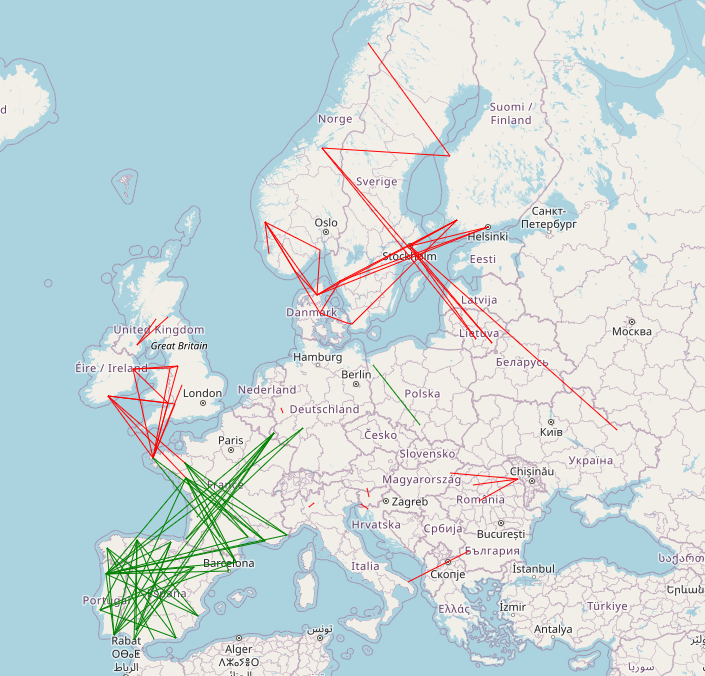

In [33]:
slowest_paths = sorted_paths[0:500]
fastest_paths = sorted_paths[-500:]
map_center = [50.0, 15.0]
mymap_plane = folium.Map(location=map_center, zoom_start=4)
for speed, route in slowest_paths:
    source, dest = route
    lat1, lng1 = g.nodes[source]["pos"]
    lat2, lng2 = g.nodes[dest]["pos"]

    folium.PolyLine(
        locations=[(lat1, lng1), (lat2, lng2)],
        color='red',  
        popup=f"Duration: {duration}",
        weight=1
    ).add_to(mymap_plane)

for speed, route in fastest_paths:
    source, dest = route
    lat1, lng1 = g.nodes[source]["pos"]
    lat2, lng2 = g.nodes[dest]["pos"]

    folium.PolyLine(
        locations=[(lat1, lng1), (lat2, lng2)],
        color='green',  
        popup=f"Duration: {duration}",
        weight=1
    ).add_to(mymap_plane)

# saving the map as an HTML file
#map_filename_plane = "shortest_duration_by_plane_map.html"
#mymap_plane.save(map_filename_plane)

# display the map
#IFrame(src=map_filename_plane, width=800, height=600)

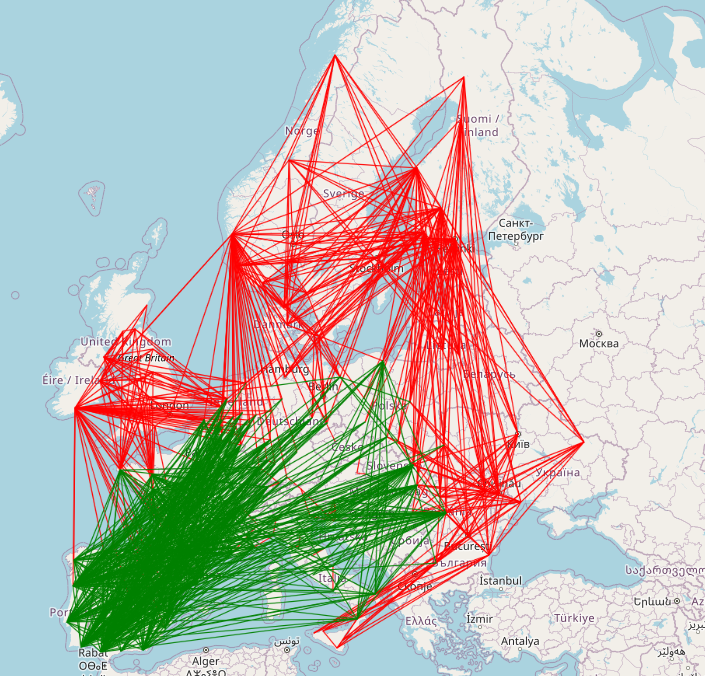

### Finding and Displaying train/car routes that are as fast as or faster than plane connections.

In [23]:
data = {
    "car_duration": car_duration,
    "plane_duration": plane_duration,
    "train_duration": train_duration,
    "train_plane_ratio": train_plain_ratio,
    "car_plane_ratio": car_plane_ratio,
    "train_car_ratio": train_car_ratio,
    "distances": air_distances,
    "source": sources,
    "destination": destinations,
}
df = pd.DataFrame(data = data)
df

,car_duration,plane_duration,train_duration,train_plane_ratio,car_plane_ratio,train_car_ratio,distances,source,destination
0,298,216.000000,370.800000,1.716667,1.379630,1.244295,305812,Graz,Innsbruck
1,96,192.216667,189.383333,0.985260,0.499436,1.972743,98384,Graz,Klagenfurt
2,150,216.216667,197.900000,0.915286,0.693749,1.319333,162331,Graz,Linz
3,182,211.716667,257.016667,1.213965,0.859639,1.412179,197241,Graz,Salzburg
4,133,214.833333,166.583333,0.775407,0.619085,1.252506,144485,Graz,Vienna
...,...,...,...,...,...,...,...,...,...
11170,316,241.583333,169.616667,0.702104,1.308037,0.536762,398471,London,Newcastle
11171,107,216.200000,94.983333,0.439331,0.494912,0.887695,110990,London,Southampton
11172,166,224.950000,140.733333,0.625621,0.737942,0.847791,171393,Manchester,Newcastle
11173,246,229.566667,250.100000,1.089444,1.071584,1.016667,291437,Manchester,Southampton


### Routes in which cars are the fastest

In [30]:
car_routes = df.query("car_duration < plane_duration & car_duration < train_duration")[["source", "destination"]].values
map_center = [50.0, 15.0]
mymap_plane = folium.Map(location=map_center, zoom_start=4)
for source, dest in car_routes:
    lat1, lng1 = g.nodes[source]["pos"]
    lat2, lng2 = g.nodes[dest]["pos"]

    folium.PolyLine(
        locations=[(lat1, lng1), (lat2, lng2)],
        color='green',  
        popup=f"Duration: {duration}",
        weight=1
    ).add_to(mymap_plane)

    
# saving the map as an HTML file
map_filename_plane = "shortest_duration_by_plane_map.html"
#mymap_plane.save(map_filename_plane)

# display the map
#IFrame(src=map_filename_plane, width=800, height=600)

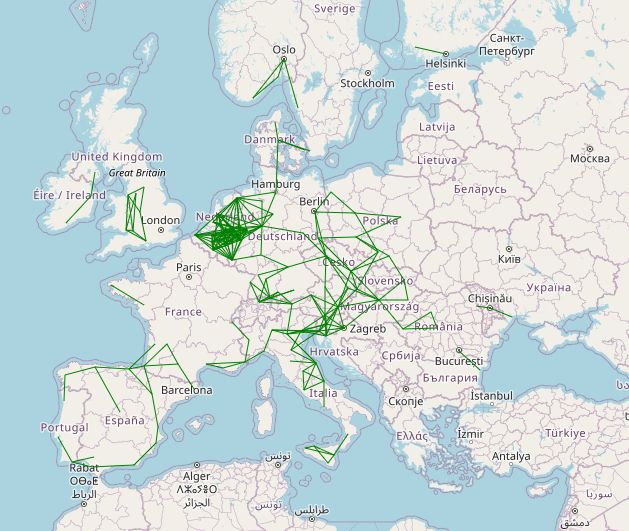

### Routes on which trains are the fastest

In [31]:
train_routes = df.query("train_duration < plane_duration & train_duration < car_duration")[["source", "destination"]].values
map_center = [50.0, 15.0]
mymap_plane = folium.Map(location=map_center, zoom_start=4)
for source, dest in train_routes:
    slowest_paths = sorted_paths[0:500]
    fastest_paths = sorted_paths[-500:]

    lat1, lng1 = g.nodes[source]["pos"]
    lat2, lng2 = g.nodes[dest]["pos"]

    folium.PolyLine(
        locations=[(lat1, lng1), (lat2, lng2)],
        color='green',  
        popup=f"Duration: {duration}",
        weight=1
    ).add_to(mymap_plane)

    
# saving the map as an HTML file
map_filename_plane = "shortest_duration_by_plane_map.html"
mymap_plane.save(map_filename_plane)

# display the map
#IFrame(src=map_filename_plane, width=800, height=600)

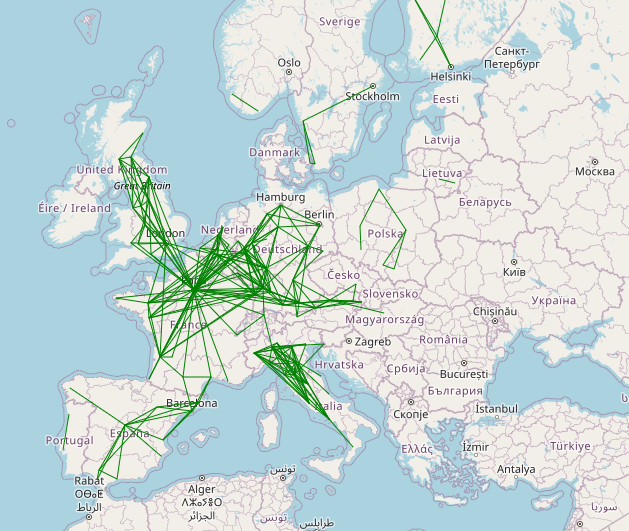